# Full Flow
0. EDA
1. 파생변수 생성
2. 데이터 전처리
   - 특수문자 및 기호 등 필요없는 문자 제거
   - 대소문자 모두 소문자로 통일
   - 이름 | 불용어(분석에 필요없는 토큰) 제거 => TF-IDF 적용시 해결 가능, 이름 제거하는게 낫나 아니면 살리는게 낫나
   - 어근 추츨을 통한 텍스트 정규화 작업
   ----------------------------------
   - TF-IDF
   ---------------------------------
   - 벡터화 함수 적용
   ---------------------------------
   - 타켓 변수 불균형 해결
3. 모델 적합     
  **CatBoost**
4. 하이퍼파라미터튜닝
  - optuna
5. 모델 앙상블

# CatBoost
Catboost는 이름에서도 유추 가능하듯이 Cat, Category 즉 범주형 변수가 많은 데이터를 학습할 때 성능이 좋음

https://julie-tech.tistory.com/119

# 라이브러리 및 데이터 불러오기

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Catboost 모델링
from catboost import CatBoostClassifier, Pool

In [3]:
import nltk # 문장 토크나이저
nltk.download('all')

from nltk.corpus import names #corpus=말뭉치,이름 관련 부분 다루기 위한 객체

from nltk.corpus import stopwords # 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [4]:
# 구글 드라이브에서 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import zipfile

# ZIP 파일 열기
with zipfile.ZipFile('/content/gdrive/MyDrive/0000/dacon_lawwinner/open.zip', 'r') as zip_ref:
    # 파일 목록 가져오기
    file_list = zip_ref.namelist()

    # 파일 목록 출력
    for file in file_list:
        print(file)

    # 모든 파일 압축 해제
    zip_ref.extractall()

sample_submission.csv
test.csv
train.csv


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# 파생변수 생성

### sentence / word Len

##### train

In [7]:
train['sen_len'] = 0 # 문장 토큰화
train['word_len'] = 0 # 단어 토큰화

for i in range(len(train)):
  train.sen_len[i] = len(nltk.sent_tokenize(train.facts[i]))
  train.word_len[i] = len(word_tokenize(train.facts[i]))

train = train[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len', 'first_party_winner']]
train.head(10)

,ID,first_party,second_party,facts,sen_len,word_len,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1
5,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",11,210,1
6,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,7,264,1
7,TRAIN_0007,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",6,205,1
8,TRAIN_0008,"Ron Davis, Acting Warden",Hector Ayala,"Hector Ayala, a Hispanic man, was charged with...",12,478,1
9,TRAIN_0009,Paul A. McDaniel,"Selma Cash Paty, et al.","Since its first state Constitution in 1796, Te...",7,144,1


##### test

In [8]:
test['sen_len'] = 0 # 문장 토큰화
test['word_len'] = 0 # 단어 토큰화

for i in range(len(test)):
  test.sen_len[i] = len(nltk.sent_tokenize(test.facts[i]))
  test.word_len[i] = len(word_tokenize(test.facts[i]))

test = test[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len']]
test.head(10)

,ID,first_party,second_party,facts,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",7,181
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",6,154
5,TEST_0005,Air Line Pilots Association,Miller,"The Air Line Pilots Association (ALPA), a priv...",9,163
6,TEST_0006,Traffic Stream (BVI) Infrastructure Ltd.,JPMorgan Chase Bank,Traffic Stream (BVI) Infrastructure Ltd. is a ...,5,177
7,TEST_0007,NRG Power Marketing LLC et al.,Maine Public Utilities Commission et al.,The Maine Public Utilities Commission along wi...,7,194
8,TEST_0008,United States,Deondery Chambers,Deondery Chambers pled guilty to being a felon...,8,243
9,TEST_0009,United States Catholic Conference,"Abortion Rights Mobilization, Inc.","Abortion Rights Mobilization, Inc. and a colle...",6,225


### issued_area

#### keybert
원본 문서를 가장 잘 나타내는 중요한 용어 또는 구문을 찾아내는 작업
- Bert를 이용해 문서레벨에서의 주제를 파악
- N-gram을 위해 단어 임베딩
- 코사인 유사도 계산해 어떤 N-gram 단어 또는 구가 문서와 가장 유사한지 확인    


**MMR**   
검색 엔진 내에서 본문 검색 관련해 검색에 따른 결과의 다양성과 연관성을 조절하는 방법
- 문서와 가장 유사한 키워드 선택
- 문서와 비슷하면서도 이미 선택한 키워드와 비슷하지 않은 새 후보 반복적으로 선택


In [ ]:
!pip install keybert

In [11]:
from keybert import KeyBERT

In [ ]:
# 중요 어구 추출
'''kw_model = KeyBERT()
keywords = kw_model.extract_keywords(train['facts'],
                                                keyphrase_ngram_range=(2,4),
                                                use_maxsum = True,
                                                top_n = 10)'''

In [ ]:
# 중요 단어 추출
train['fact_processing'] = train['facts'].apply(cleaning)
array_text = train['fact_processing'].to_numpy()

bow_cleaned = []

kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
for j in range(len(array_text)):
    keywords1 = kw_extractor.extract_keywords(array_text[j])
    bow_cleaned.append(keywords1)

In [ ]:
keywords_list = [[item[0] for item in sublist] for sublist in bow_cleaned]
keywords_list

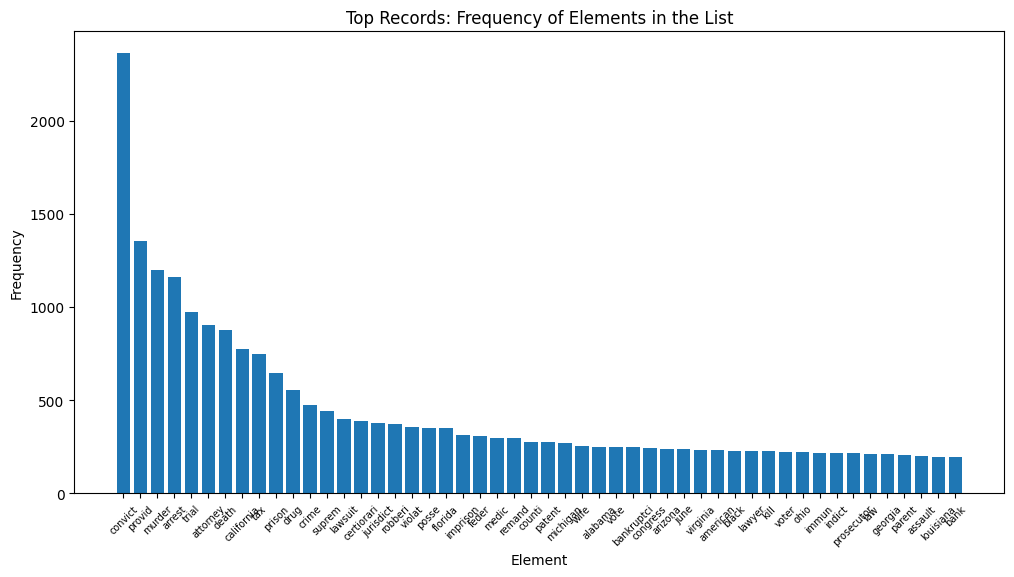

In [174]:
import matplotlib.pyplot as plt

# 통합 keywords 리스트 생성
for i in range(2477):
  lst = lst + keywords_list[i+1]

# 원소별 빈도 계산
counts = {}
for item in lst:
    counts[item] = counts.get(item, 0) + 1

# 빈도를 기준으로 내림차순으로 정렬하여 상위 레코드 선택
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
top_records = sorted_counts[:50]  # 상위 5개 레코드만 선택

# 그래프 크기 조정
plt.figure(figsize=(12, 6))

# 막대 그래프 생성
labels = [record[0] for record in top_records]
values = [record[1] for record in top_records]
plt.bar(labels, values)
plt.xlabel('Element')
plt.ylabel('Frequency')
plt.title('Top Records: Frequency of Elements in the List')
# x축 눈금 레이블의 속성 변경
plt.xticks(fontsize=7,rotation=45)

plt.show()

In [26]:
train['keywords_list'] = keywords_list
train.head(5)

,ID,first_party,second_party,facts,sen_len,word_len,first_party_winner,fact_processing,keywords_list
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1,june phil st amant candid public offic made te...,"[sheriff, louisiana, june, communist, baton]"
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0,ramon nelson ride bike suffer lethal blow back...,"[murder, death, convict, prison, drug]"
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1,alabama state court convict billi joe magwood ...,"[murder, prison, convict, death, alabama]"
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0,victor linklett convict state court evid illeg...,"[retrial, convict, trial, suprem, fourth]"
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1,april selma alabama intrud broke apart daughte...,"[april, daughter, selma, death, alabama]"


#### 판결 유형 대분류표 생성
**Criminal Law**
- murder, robbery, rape,theft
- drug, traffic accident
- national security       

**Civil Law**
-  lawsuits, claims for damages, contract violations
-  divorce, child custody, inheritance
-  labor unions, wage claims, terminations     

**Constitutional Law**
- Constitutional Petitions
- constitutional disputes
-  individual constitutional rights       



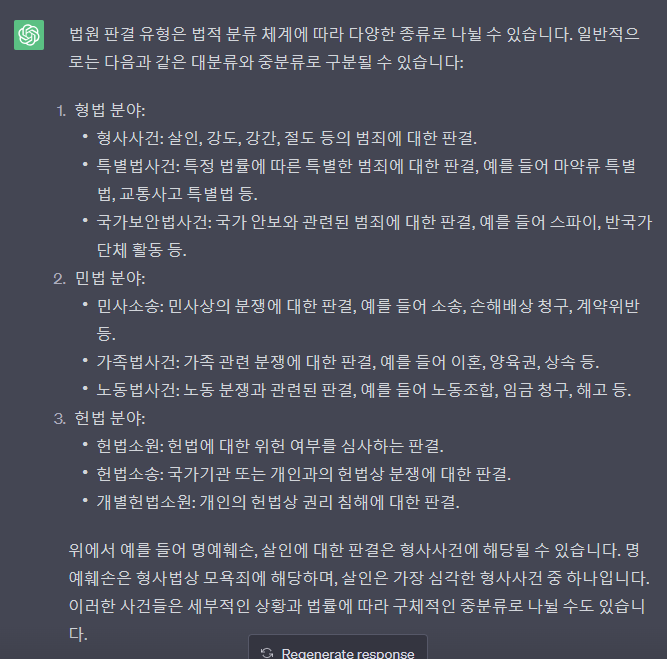

In [231]:
## 형사
criminal = ['murder', 'robbery', 'rape', 'theft','larceny', 'criminal','assault',
'drug', 'traffic', 'spy', 'espionage', 'marijuana', 'rape', 'burglarious']

## 민사
civil = ['lawsuits', 'contract violations',
'divorce', 'child custody', 'inheritance',
'labor unions' , 'wage claims', 'terminations',
'defamation','Slander', 'libel', 'reputation','bankruptcy', 'fraud','kidnap'
]

## 헌법
constitutional = ['Constitutional Petitions',
'constitutional disputes',
'individual constitutional rights']

df = pd.DataFrame({
    'main_words':criminal + civil + constitutional,
    'category' : len(criminal)*["criminal"]+len(civil)*["civil"]+len(constitutional)*["constitutional"]
})

df['main_procssing']= df['main_words'].apply(cleaning)
df

,main_words,category,main_procssing
0,murder,criminal,murder
1,robbery,criminal,robberi
2,rape,criminal,rape
3,theft,criminal,theft
4,larceny,criminal,larceni
5,criminal,criminal,crimin
6,assault,criminal,assault
7,drug,criminal,drug
8,traffic,criminal,traffic
9,spy,criminal,spi


In [142]:
from nltk.corpus import wordnet

In [143]:
'''lst = criminal

for j in criminal:
  term = j
  # term로 wordnet의 synsets 생성
  synsets = wordnet.synsets(term)

  # Synsets 속성: 이름/품사/정의/부명제
  for i, synset in enumerate(synsets):
    #  print('Definition:', synset.definition())
      lst = synset.lemma_names() + lst
     # print('Lemmas:', synset.lemma_names())

  # 최종 리스트 반환
  lst = list(set(lst))

criminal = lst'''

In [144]:
'''lst = civil

for j in civil:
  term = j
  # term로 wordnet의 synsets 생성
  synsets = wordnet.synsets(term)

  # Synsets 속성: 이름/품사/정의/부명제
  for i, synset in enumerate(synsets):
    #  print('Definition:', synset.definition())
      lst = synset.lemma_names() + lst
     # print('Lemmas:', synset.lemma_names())

  # 최종 리스트 반환
  lst = list(set(lst))

civil = lst'''

In [145]:
'''lst = constitutional

for j in constitutional:
  term = j
  # term로 wordnet의 synsets 생성
  synsets = wordnet.synsets(term)

  # Synsets 속성: 이름/품사/정의/부명제
  for i, synset in enumerate(synsets):
    #  print('Definition:', synset.definition())
      lst = synset.lemma_names() + lst
     # print('Lemmas:', synset.lemma_names())

  # 최종 리스트 반환
  lst = list(set(lst))

constitutional = lst'''

In [189]:
'''df = pd.DataFrame({
    'main_words':criminal + civil + constitutional,
    'category' : len(criminal)*["criminal"]+len(civil)*["civil"]+len(constitutional)*["constitutional"]
})

df['main_procssing']= df['main_words'].apply(cleaning)
df'''

,main_words,category,main_procssing
0,murder,criminal,murder
1,robbery,criminal,robberi
2,rape,criminal,rape
3,theft,criminal,theft
4,larceny,criminal,larceni
5,criminal,criminal,crimin
6,assault,criminal,assault
7,drug,criminal,drug
8,traffic,criminal,traffic
9,spy,criminal,spi


#### train : 최종 category 변수 생성

In [215]:
def finding_cateory(lst):
    k = 0
    for item in lst:
      if item in df.main_procssing.values:
        k = df.loc[df['main_procssing'] == item, 'category'].values[0]
      # 값이 저장되었다면 for 구문 중단
      if k != 0:
        break
    # k 값이 없다면 기타
    if k == 0:
      k = 'others'
    return k

In [238]:
train['category'] = 0

for i in range(len(train)):
  train['category'][i] = finding_cateory(keywords_list[i])

In [239]:
train = train[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len', 'first_party_winner'  ]]
train = train.rename(columns={'category':'issued_area'})
train

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",others,7,201,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,criminal,7,219,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,criminal,8,191,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,others,3,59,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",others,9,200,1
...,...,...,...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,others,5,144,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",others,7,184,1
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",criminal,6,195,0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",others,8,194,0


#### test

In [235]:
test['category'] = 0

for i in range(len(test)):
  test['category'][i] = finding_cateory(keywords_list[i])

In [241]:
test = test[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len']]
test = test.rename(columns={'category':'issued_area'})
test

,ID,first_party,second_party,facts,issued_area,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,others,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,criminal,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",criminal,7,181
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,others,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",others,6,154
...,...,...,...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",According to Executive Order No. 12807 signed ...,criminal,5,156
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",Section 109(a) of the Clean Air Act (CAA) requ...,criminal,7,221
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,Linda Matteo and John Madigan created a plan f...,others,12,236
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,"In 1972, the North Carolina Board of Agricultu...",others,3,84


### winning_percent
**first_party_win_percent**
  첫 번째 당사자가 승소할 확률.
- 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
- test에서는 first_party가 train의 first_party와 겹치는 경우에는 해당 사람의 승소할 확률을 반영함. 겹치지 않는 경우는 0.5로 반영함.

##### train

In [242]:
# winner: 해당 사건에서 승소한 사람
# win_percentage: 승소한 사람이 다른 사건에서도 승소할 확률

train['winner']=0
for i in range(2478):
  if train['first_party_winner'][i]==1:
    train['winner'][i] = train['first_party'][i]
  else:
    train['winner'][i] = train['second_party'][i]

train['win_percentage']=0
for i in range(2478):
  winner_exp = len(train.loc[train['first_party'] == train['winner'][i]])
  loose_exp = len(train.loc[train['second_party'] == train['winner'][i]])
  train['win_percentage'][i]= len(train.loc[train['winner'] == train['winner'][i]]) /(winner_exp + loose_exp)

In [243]:
# first_party_frequency: first_party가 나타난 빈도
# first_party_win_percent: first_party가 승소할 확률
train['first_party_win_percent'] = 0
train['first_party_frequency'] = 0

for i in range(2478):
  train['first_party_frequency'][i] = len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]])

  # 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
  if train['first_party_frequency'][i] > 1:
    p = len(train.loc[train['winner'] == train['first_party'][i]]) / train['first_party_frequency'][i]
    train['first_party_win_percent'][i] = p
  else:
    train['first_party_win_percent'][i] = 0.5

In [244]:
train = train.drop(['winner',	'win_percentage','first_party_frequency'],axis=1)
train.tail(30)

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_winner,first_party_win_percent
2448,TRAIN_2448,Pennsylvania,Delaware Valley Citizens' Council for Clean Air,"In April of 1973, pursuant to the Clean Air Ac...",others,13,394,1,0.62500
2449,TRAIN_2449,WesternGeco LLC,ION Geophysical Corporation,The US Supreme Court issued a 2016 order grant...,others,9,254,1,0.50000
2450,TRAIN_2450,Helling,McKinney,"William McKinney, a Nevada state prisoner, sue...",others,4,163,0,0.50000
2451,TRAIN_2451,"Hana Financial, Inc.","Hana Bank, et al.","In the spring of 1994, Hana Bank, a Korean ent...",others,10,304,0,0.50000
2452,TRAIN_2452,Police Department of the City of Chicago,Mosley,Chicago adopted an ordinance prohibiting picke...,others,3,54,0,0.50000
2453,TRAIN_2453,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","On October 10, 1980, an Oklahoma City police o...",others,5,180,1,0.50000
2454,TRAIN_2454,Rotella,Wood,Mark Rotella was admitted to a Brookhaven Psyc...,others,8,254,0,0.50000
2455,TRAIN_2455,Gregory Houston Holt,"Ray Hobbs, Director, Arkansas Department of Co...",Gregory Holt (also known as Abdul Maalik Muham...,others,6,190,1,0.50000
2456,TRAIN_2456,United States,Lanier,David W. Lanier was convicted under 18 U.S.C. ...,criminal,7,223,1,0.57868
2457,TRAIN_2457,Crosby,National Foreign Trade Council,"In 1996, the Massachusetts Burma Law, which re...",others,7,189,0,0.50000


##### test

In [245]:
# train 기준 컬럼 생성
train_first_party = train[['first_party','first_party_win_percent']]
train_first_party = train_first_party.drop_duplicates()
train_first_party.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2470    False
2473    False
2474    False
2475    False
2477    False
Length: 2110, dtype: bool

In [246]:
# 병합
test_percent = pd.merge(test.first_party, train_first_party, how='left')
test_percent = test_percent.fillna(0.5)

# test에 새로운 컬럼 추가
test['first_party_win_percent'] = test_percent['first_party_win_percent']

### party name 치환

In [255]:
# 이름 치환함수
def replace_name(name, text, replace_word):
    names = name.split('|')
    words = text.split()
    for word in words:
      for n in names:
        if n in word:
            text = text.replace(word, replace_word)

    return text

# 정규표현식으로 first_party 여러번 중복 연달아 나오는 거 한 번만 나오게 바꾸기
def remove_duplicates(text):
    modified_text1 = re.sub(r'(first_party\s*)+', 'first_party ', text)
    modified_text2 = re.sub(r'(second_party\s*)+', 'second_party ', modified_text1)
    return modified_text2

#### train

In [251]:
# 데이터 손실 방지를 위해 값 복사
train['first_party1'] = train['first_party']
train['second_party1'] = train['second_party']
train['facts1'] = train['facts']

# 이름 치환을 위한 base
train['first_party1'] = train['first_party1'].str.replace(" ", "|")
train['second_party1'] = train['second_party1'].str.replace(" ", "|")

In [256]:
# 함수 각각 적용
for i in range(len(train)):
  train['facts1'][i] = replace_name(train['first_party1'][i], train['facts1'][i], 'first_party')
  train['facts1'][i] = replace_name(train['second_party1'][i], train['facts1'][i], 'second_party')

  train['facts1'][i] = remove_duplicates(train['facts1'][i])

#### test

In [257]:
# 데이터 손실 방지를 위해 값 복사
test['first_party1'] = test['first_party']
test['second_party1'] = test['second_party']
test['facts1'] = test['facts']

# 이름 치환을 위한 base
test['first_party1'] = test['first_party1'].str.replace(" ", "|")
test['second_party1'] = test['second_party1'].str.replace(" ", "|")

In [259]:
# 함수 각각 적용
for i in range(len(test)):
  test['facts1'][i] = replace_name(test['first_party1'][i], test['facts1'][i], 'first_party')
  test['facts1'][i] = replace_name(test['second_party1'][i], test['facts1'][i], 'second_party')

  test['facts1'][i] = remove_duplicates(test['facts1'][i])

# Data Preprocessing

In [12]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
all_names=set(names.words())
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [ps.stem(word) for word in no_stops]

    # 표제어 추출 Lemmatisation (convert the word into root word)
    lem_text = [lem.lemmatize(word) for word in stemmer_words]

    # back to string from list
    text = " ".join(lem_text)

    return text

In [ ]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    # 데이터 클리닝
    df['fact_processing'] = df['facts'].apply(cleaning)

    # TF-IDF -- 파라미터 조정 필요?
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [ ]:
# 벡터화 함수 적용
X = get_vector(vectorizer, train, True)
Y = train["first_party_winner"]
X_train = np.asarray(X) # np.array 활용 및 적용
Y_train = np.asarray(Y)

X_test = get_vector(vectorizer, test, False)

UnboundLocalError: ignored

# Define Model & Train

## self weight
전체 데이터에서 1:0=66:33 인 비율로, 이를 해결하기 위해 클래스별 가중치를 계산해 이를 고려해 학습 시도.
따라서 y값 데이터의 불균형 해결

+ 다른 방법으로 해결하고 싶다면
+ +) 타겟 변수 불균형 문제가 있어 클래스별 가중치를 적용해 모델 학습을 진행

In [ ]:
counts = list(Y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.33454398708635996, 0.66545601291364]


## 모델 적합

In [ ]:
model = CatBoostClassifier(random_seed=42,class_weights=class_weight, verbose=0)
model.fit(X_train, Y_train)

## 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'n_estimators': [100, 200,300.400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(CatBoostClassifier(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=  43.7s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=  44.9s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=  38.6s
[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=  40.3s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=nan total time=  40.8s
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=nan total time=  46.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=nan total time=  39.4s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=nan total time=  40.9s
[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_es

# Inference & Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
X_test = np.asarray(X_test)
Y_pred = model.predict(X_test)

In [ ]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_catboost2.csv', index=False)
print('Done')

Done
